## Analyse comportementale

In [1]:
# modules
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.ndimage import gaussian_filter1d
from scipy.stats import sem
from matplotlib import colormaps as clm

In [6]:
# load data
# path_base = r"Z:\gGermain\2024-09-17"
path_base = r"C:\Users\gabri\Desktop\data\2024-09-17"

beh_data = np.load(path_base + "\\3\\SourisWF_SynG8s_3-09172024153215-0000_proc.npy", allow_pickle=True).item()
violet_t = np.load(path_base + "\\3\\405ts.npy")
blue_t = np.load(path_base + "\\3\\470ts.npy")
green_t = np.load(path_base + "\\3\\530ts.npy")
red_t = np.load(path_base + "\\3\\625ts.npy")
lsci_t = np.load(path_base + "\\3\\785ts.npy")

time = np.sort(np.concatenate((violet_t, blue_t, green_t, red_t, lsci_t)))*1.0002


motion = beh_data['motion'][1]
motion = gaussian_filter1d(motion, sigma=2)
pupil = beh_data['pupil'][0]['area_smooth']
blink = beh_data['blink'][0]
time = time[0:len(motion)]
# print(len(time))
# print(len(motion))

sigs = (motion, pupil, blink)
# grossier, aller chercher timestamps frames
# time = np.array(list(range(len(motion))))/50.18


In [7]:
# air puffs

AP_times = np.array([  12.01,   35.2 ,   46.51,   74.12,   91.14,  103.63,  114.48,
       132.14,  142.77,  169.61,  182.33,  197.83,  209.56,  223.5 ,
       239.35,  252.31,  263.77,  279.97,  297.53,  310.62,  323.38,
       335.92,  365.67,  383.93,  402.83,  417.51,  430.48,  440.9 ,
       456.7 ,  468.25])#,  480.64,  492.07,  505.46,  519.24,  536.92,
       #  552.43,  576.9 ,  596.15,  612.13,  632.1 ,  645.22,  664.01,
       #  686.24,  703.4 ,  713.56,  729.68,  740.07,  752.43,  765.83,
       #  777.35,  789.49,  800.04,  810.43,  824.76,  839.67,  850.88,
       #  860.94,  874.11,  888.13,  904.49,  922.57,  935.73,  947.48,
       #  963.51,  973.88,  990.72, 1003.71, 1020.55, 1032.  , 1042.46,
       # 1055.49, 1078.02, 1099.15, 1121.05, 1132.5 , 1161.08, 1172.75,
       # 1188.24, 1201.83, 1230.68, 1243.77, 1255.68, 1280.08, 1294.65,
       # 1322.31, 1347.66, 1375.94, 1385.98, 1399.58, 1411.88, 1430.66,
       # 1447.55, 1458.09, 1468.23, 1478.57, 1493.51, 1503.51, 1520.58,
       # 1535.84, 1548.77])

AP_idx = []
for ti in AP_times:
       AP_idx.append(np.argmin(np.absolute(time-ti)))
# Dirac où AP dans times series
AP_series = np.zeros(len(time))
AP_series[AP_idx] = 1

## ALIGN DATA
inf = 30*5
sup = 100*5
aligned_data_raw = np.zeros((len(sigs), len(AP_idx), inf+sup))
aligned_data_norm = np.zeros((len(sigs), len(AP_idx), inf+sup))
for idx, sig in enumerate(sigs):
  for i in range(len(AP_idx)):
    plage = sig[int(AP_idx[i]-inf):int(AP_idx[i]+sup)]
    aligned_data_raw[idx,i,:] = plage
    aligned_data_norm[idx,i,:] = (plage-np.min(plage))/(np.max(plage)-np.min(plage))

  aligned_data = aligned_data_raw



les time stamps des frames ne semblent pas être alignés avec les ai puffs, prendre time stamps camera au lieu d'estimer time

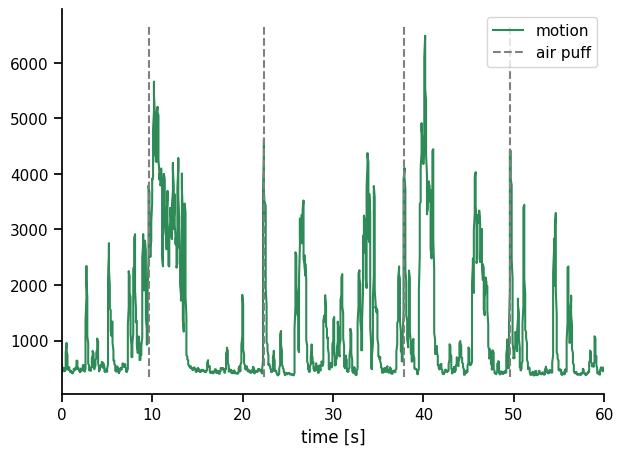

In [8]:
# %matplotlib qt5
%matplotlib inline
sns.set_context('notebook')
fg = plt.figure(figsize=(7,5))
plt.plot(time-160, motion, color='seagreen', label="motion", )
# plt.plot(time, pupil, label="pupil")
# plt.plot(time, (blink-blink.min())/6, label="blink")
plt.vlines(AP_times-160, motion.min(), motion.max(), color='grey', linestyles=('--'), label='air puff')
plt.xlim(0, 220-160)
# plt.xlim(0, 120)
plt.xlabel('time [s]')
# plt.ylabel('motion energy [a.u.]')
sns.despine()
plt.legend()
# plt.savefig("whisker_motion.svg")
# plt.show()


(650,)
(650,)
(650,)


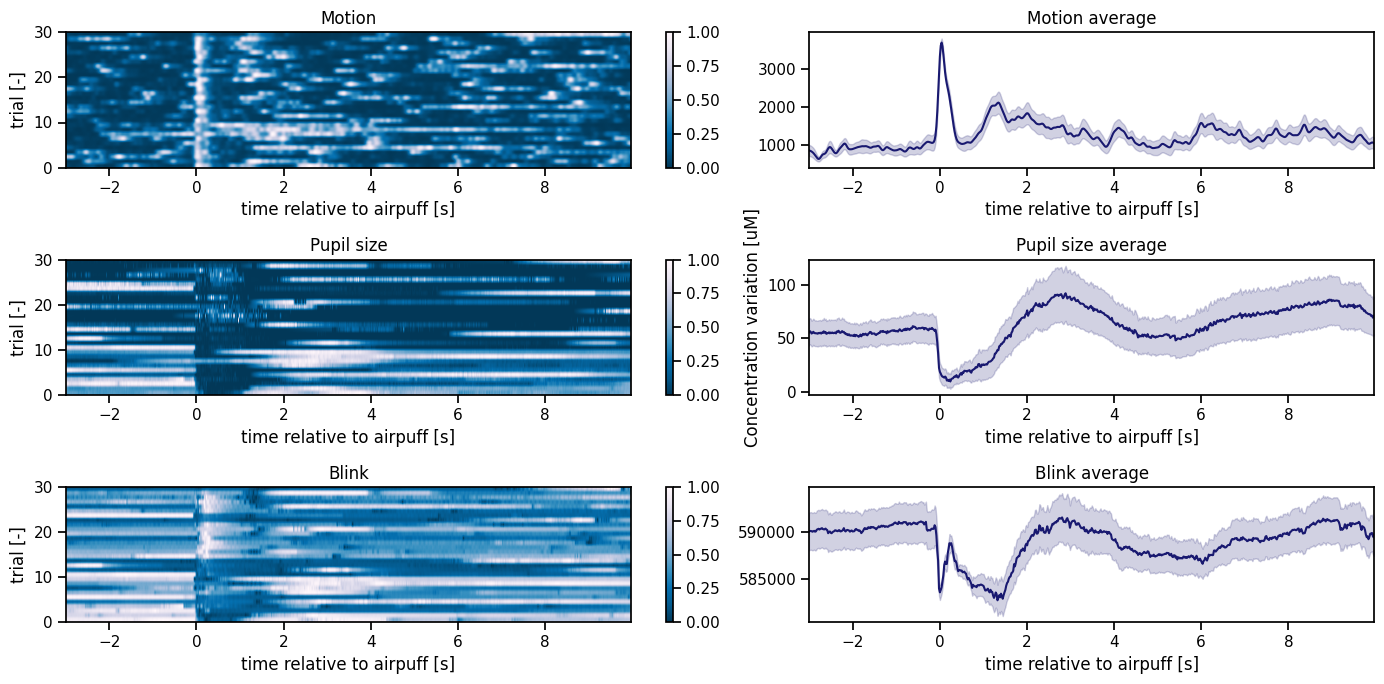

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(14,7), width_ratios=[5, 4])
sns.set_context('notebook')

titles = ("Motion", "Pupil size", "Blink")
titles_av = ("Motion average", "Pupil size average", "Blink average")
cols = ('midnightblue', 'midnightblue', 'midnightblue')
cmaps = (clm['PuBu_r'], clm['PuBu_r'], clm['PuBu_r'])


for idx, (sig, cmap, title, title_av) in enumerate(zip(aligned_data, cmaps, titles, titles_av)):
  ax = plt.subplot(3, 2, 2*idx+1)
  ax.set_title(title)
  ax.set_xlabel('time relative to airpuff [s]')
  ax.set_ylabel("trial [-]")
  pos = ax.imshow(aligned_data_norm[idx,:,:], origin='lower', extent=[time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]], 0, len(AP_times)], aspect='auto', cmap=cmap)
  fig.colorbar(pos, ax=ax)

for idx, (sig, col, title, title_av) in enumerate(zip(aligned_data_raw, cols, titles, titles_av)):
    avg_data = np.mean(sig, axis=0)
    print(avg_data.shape)
    std_data = sem(sig, axis=0)

    ax = plt.subplot(3, 2, 2*idx+2)
    ax.set_title(title_av)
    # ax.vlines(0, avg_data.min(), avg_data.max(), color='grey', linestyles='-')
    # ax.plot(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data, color=col)
    ax.plot(np.linspace(-3, 10, 650), avg_data, color=col)
    # ax.fill_between(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data-std_data, avg_data+std_data, color=col, alpha=0.2)
    ax.fill_between(np.linspace(-3, 10, 650), avg_data-std_data, avg_data+std_data, color=col, alpha=0.2)
    ax.set_xlim(time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]])
    ax.set_xlabel('time relative to airpuff [s]')
    if idx == 1:
        ax.set_ylabel("Concentration variation [uM]")
    # sns.despine()
    plt.tight_layout()

# plt.savefig("behavior_rasters.svg")